In [1]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
import sys
from collections import defaultdict 
import jax
import flax
import chex
from jaxtyping import ArrayLike
from typing import Union, TypeVar
import numpy as np
import matplotlib.pyplot as plt
import traceback
import jax.numpy as jnp
from collections import Counter

from tracr.compiler.validating import validate
from tracr.rasp.rasp import Map, SequenceMap, LinearSequenceMap, Select, Aggregate, Comparison, SelectorWidth, indices, tokens 
from tracr.rasp import rasp
from tracr.compiler import compiling
from tracr.compiler.assemble import AssembledTransformerModel
from tracr.compiler.craft_model_to_transformer import NoTokensError
from tracr.compiler.basis_inference import InvalidValueSetError
from tracr.compiler import rasp_to_graph


from decompile_tracr.dataset import lib
from decompile_tracr.dataset import data_utils
from decompile_tracr.dataset import config
from decompile_tracr.tokenizing import tokenizer
from decompile_tracr.tokenizing import vocab
from decompile_tracr.sampling import sampling
from decompile_tracr.sampling import rasp_utils
from decompile_tracr.sampling.validate import is_valid


rng = np.random.default_rng(0)

In [2]:
rng = np.random.default_rng(None)

TEST_INPUTS = [rasp_utils.sample_test_input(rng, max_seq_len=5, min_seq_len=5,
                                            vocab=set(range(10))) 
               for _ in range(50)]
LENGTH = 5
PROGRAMS = [sampling.sample(rng, program_length=LENGTH) for _ in range(300)]
OUTPUTS = [[p(x) for x in TEST_INPUTS] for p in PROGRAMS]
OUTPUTS = np.array(OUTPUTS, dtype=float)
OUTPUTS = np.nan_to_num(OUTPUTS, nan=0.0)


def test_sample():
    for p in PROGRAMS:
        assert rasp_utils.count_sops(p) == LENGTH


def test_validity_without_compiling():
    """Test that sampled programs are valid."""
    valid = [
        all(is_valid(p, x) for x in TEST_INPUTS) for p in PROGRAMS
    ]
    n_programs_valid = sum(valid)
    assert n_programs_valid / len(PROGRAMS) > 0.95, (
        f"Only {n_programs_valid} / {len(PROGRAMS) * 100}\% of programs are valid.")


def test_constant_wrt_input():
    """Test that sampled programs are not constant wrt input."""
    are_constant = [_constant_wrt_input(o) for o in OUTPUTS]
    frac_constant = sum(are_constant) / len(OUTPUTS)
    assert frac_constant < 0.05, (
        f"{frac_constant*100}% of programs produce the same output for > 80% of test inputs."
    )


def test_low_var():
    """Test that sampled programs have a reasonable amount of variance wrt input"""
    stds = np.std(OUTPUTS, axis=1).sum(axis=-1)  # std across test inputs; sum across output sequence
    are_low_var = stds < 0.01
    frac_low_var = sum(are_low_var) / len(stds)
    print(f"{frac_low_var*100}% of programs have low variance in output.")


def test_outputs_within_range(magnitude=1e4):
    """Test that program outputs are within a reasonable range."""
    print("outputs:", OUTPUTS)
    print("any none?", np.any(np.isnan(np.array(OUTPUTS, dtype=float))))
    assert np.all(np.abs(OUTPUTS) < magnitude), (
        f"Outputs are not within range (-{magnitude}, {magnitude})."
        f"Found min: {np.min(OUTPUTS)}, max: {np.max(OUTPUTS)}."
    )


def _constant_wrt_input(outputs: list[tuple]) -> bool:
    """Check if program is constant wrt input. 
    Returns True if >80% of inputs produce exactly the same output.
    """
    counts = Counter(outputs)
    return counts.most_common(1)[0][1] / len(outputs) > 0.8


def _low_var(outputs: list[list], threshold=0.01) -> bool:
    """Check if program has low variance wrt input. 
    Returns True if stddev of outputs is below the threshold.
    """
    return np.std(outputs, axis=1) < threshold

sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled selector width
sampled sel

In [3]:
test_low_var()

6.333333333333334% of programs have low variance in output.


In [ ]:
systems = [
    "GPT", 
    "GPT-3 175B (davinci)",
    "GPT-2 (1.5B)",
    "GPT-2 (345M)",
    "GPT-4",
    "GPT-4V",
    "ChatGPT (gpt-3.5-turbo)",
    "GPT-4 Turbo",
]

In [4]:
outputs_buffer = OUTPUTS.copy()

data = []
for i, p in enumerate(PROGRAMS):
    data.append({
        "program": p,
        "outputs": OUTPUTS[i],
        "std": np.std(OUTPUTS[i], axis=0).sum(),
    })

In [5]:
by_std = sorted(data, key=lambda x: np.std(x['outputs']))
len(by_std)
by_std = iter(by_std)

In [6]:
p = next(by_std)
print("std:", np.std(p['outputs']))
print()
print('input: ', TEST_INPUTS[0])
rasp_utils.print_program(p['program'], test_input=TEST_INPUTS[0], full=True)
print()
print('sample outputs:', p['outputs'][:10])

std: 0.0

input:  [9, 2, 3, 6, 0]
map_548 = rasp.numerical(Map(lambda x: x != 2, indices))    # output: [True, True, False, True, True]
sequence_map_546 = rasp.categorical(SequenceMap(lambda x, y: x + y % 10, tokens, indices))    # output: [9, 3, 5, 9, 4]
select_553 = Select(sequence_map_546, sequence_map_546, predicate=Comparison.TRUE)
aggregate_552 = rasp.numerical(Aggregate(select_553, map_548))    # output: [0.8, 0.8, 0.8, 0.8, 0.8]

sample outputs: [[0.8 0.8 0.8 0.8 0.8]
 [0.8 0.8 0.8 0.8 0.8]
 [0.8 0.8 0.8 0.8 0.8]
 [0.8 0.8 0.8 0.8 0.8]
 [0.8 0.8 0.8 0.8 0.8]
 [0.8 0.8 0.8 0.8 0.8]
 [0.8 0.8 0.8 0.8 0.8]
 [0.8 0.8 0.8 0.8 0.8]
 [0.8 0.8 0.8 0.8 0.8]
 [0.8 0.8 0.8 0.8 0.8]]


In [7]:
rasp_utils.print_program(p['program'], test_input=[1,2,3,4,5], full=True)

map_548 = rasp.numerical(Map(lambda x: x != 2, indices))    # output: [True, True, False, True, True]
sequence_map_546 = rasp.categorical(SequenceMap(lambda x, y: x + y % 10, tokens, indices))    # output: [1, 3, 5, 7, 9]
select_553 = Select(sequence_map_546, sequence_map_546, predicate=Comparison.TRUE)
aggregate_552 = rasp.numerical(Aggregate(select_553, map_548))    # output: [0.8, 0.8, 0.8, 0.8, 0.8]


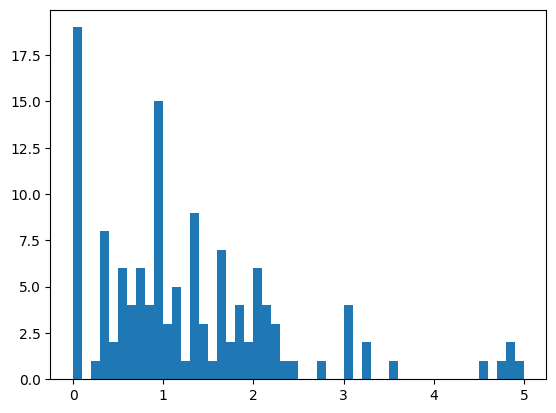

In [20]:
plt.hist([d['std'] for d in data], bins=50, range=(0, 5));

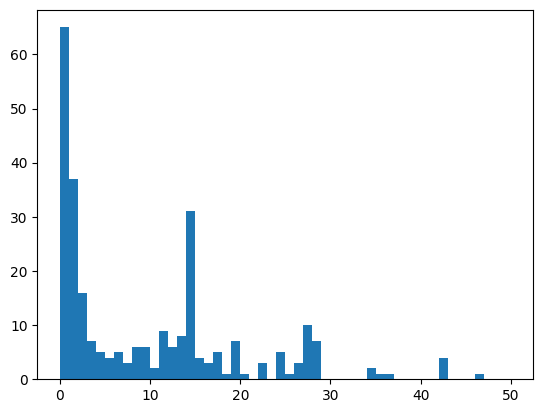

In [22]:
plt.hist([d['std'] for d in data], bins=50, range=(0, 50));